**02452** *Machine Learning*, Technical University of Denmark

- This Jupyter notebook contains exercises where you fill in missing code related to the lecture topic. *First*, try solving each task yourself. *Then* use the provided solution (an HTML file you can open in any web browser) as inspiration if needed. If you get stuck, ask a TA for help.

- Some tasks may be difficult or time-consuming - using the solution file or TA support is expected and perfectly fine, as long as you stay active and reflect on the solution.

- You are not expected to finish everything during the session. Prepare by looking at the exercises *before* the class, consult the TAs *during* class, and complete the remaining parts *at home*.

---

# Week 6: Overfitting and cross-validation

**Content:** 
- Part 1: Understanding over-fitting
- Part 2: Approximating Generalization Error through Cross-Validation. 
- Part 3: Cross-Validation for Model Evaluation
- Part 4: Feature Selection through nested cross-validation.

**Objectives:**
- Understand under- and overfitting. 
- Understand the difference between training, test and generalization error.
- Explain how cross-validation can be used for (i) performance evaluation and (ii) model selection.
- Be able to do feature-selection, and understand how it relates to over-fitting. 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import random

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
import matplotlib.gridspec as gridspec
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier

# Plotting style
sns.set_style('darkgrid')
sns.set_theme(font_scale=1.)

# Random seed
seed = 1234
np.random.seed(seed)
random.seed(seed)

# Function for plotting polynomial data
def plot_polynomial_data(X_train, y_train, X_test, y_test, func, model = None, plot_test_points=True, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    # Plot training points
    ax.plot(X_train, y_train, "o", color="tab:red", label="Training data", mec='k')

    # Plot test points and true function.
    if plot_test_points: # only plot test points if specified
        ax.plot(X_test, y_test, "x", color="tab:blue", label="Test data", alpha=0.5)
    
    # True function
    ax.plot(X_test, func(X_test), "--", color="gray", label="True function")
    
    # Plot model predictions if given
    if model is not None: # only plot predictions if specified
        x_grid = np.linspace(-1, 1, 1000).reshape(-1,1)
        ax.plot(x_grid, model.predict(x_grid), color="tab:green", label=f"Fitted model")

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_ylim(-6, 6)

def plot_fold_errors(fold_errors):
    K = fold_errors.shape[0]

    # Scale figure width with number of folds
    base_width = 6   # minimum width
    width_per_fold = 0.25  # additional width per fold
    max_width = 20   # cap to prevent it from getting absurdly wide
    fig_width = min(base_width + K * width_per_fold, max_width)
    fig_height = 6
    f = plt.figure(figsize=(fig_width, fig_height))

    bar_width = 0.35
    index = np.arange(K)
    plt.bar(index, fold_errors[:, 0], bar_width, color='tab:blue', label='Train error')
    plt.bar(index + bar_width, fold_errors[:, 1], bar_width, color='tab:red', label='Test error')
    plt.xlabel('Fold')
    plt.ylabel('RMSE')
    plt.ylim(0, max(fold_errors.flatten()) + 0.2)
    plt.xlim(-0.5, K - 0.5 + bar_width)
    plt.legend()
    plt.grid(axis='x')

    if K > 20:
        step = max(1, K // 20)  # show ~20 labels max
        plt.xticks(index[::step] + bar_width / 2, [f'{i+1}' for i in range(0, K, step)])

    else:
        plt.xticks(index + bar_width / 2, [f'{i+1}' for i in range(K)])


def bmplot(yt, xt, X):
    """
    Function plots matrix X as image with white background, black grid lines, and dark blue for selected cells.
    """
    plt.imshow(X, interpolation="none", cmap="Blues", aspect="equal", vmin=0, vmax=1)
    plt.xticks(range(0, len(xt)), xt)
    plt.yticks(range(0, len(yt)), yt)
    plt.gca().set_facecolor("white")
    for i in range(0, len(yt)):
        plt.axhline(i - 0.5, color="black")
    for i in range(0, len(xt)):
        plt.axvline(i - 0.5, color="black")
    plt.grid(False)


def plot_seq_feature_results(fold_results, feature_names):
    num_folds = len(fold_results)

    for i, res in enumerate(fold_results):
        fig, axes = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={"width_ratios": [2, 1]})
        
        # Left: MSE progression
        axes[0].plot(range(1, len(res["mse"])+1), res["mse"], marker="o")
        axes[0].set_title(f"Fold {i+1}: MSE vs #features")
        axes[0].set_xlabel("Iteration")
        axes[0].set_ylabel("MSE")

        # Right: Heatmap of feature selection order using bmplot
        grid = np.zeros((len(feature_names), len(res["features"])))
        for j, feat in enumerate(res["features"]):
            grid[feature_names.index(feat), j:] = 1

        plt.sca(axes[1])
        bmplot(feature_names, list(range(1, len(res["features"])+1)), grid)
        axes[1].set_title(f"Fold {i+1}: feature selection path")
        axes[1].set_xlabel("Iteration")
        axes[1].set_ylabel("Features")

        plt.tight_layout()
        plt.show()

    # Final summary heatmap
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={"width_ratios": [2, 1]})

    # Left: Outer test MSEs
    outer_mses = [res["outer_test_mse"] for res in fold_results]
    axes[0].bar(range(1, num_folds + 1), outer_mses, color='tab:blue')
    axes[0].set_title("Outer test MSEs per fold")
    axes[0].set_xlabel("Fold")
    axes[0].set_ylabel("Outer test MSE")
    axes[0].grid(True, axis='y')
    
    # Right: Feature usage summary
    summary = np.zeros((len(feature_names), num_folds))
    for i, res in enumerate(fold_results):
        for feat in res["features"]:
            summary[feature_names.index(feat), i] = 1

    bmplot(feature_names, range(num_folds), summary)
    axes[1].set_title("Feature usage across folds")
    axes[1].set_xlabel("Outer folds")
    axes[1].set_ylabel("Features")
    plt.tight_layout()
    plt.show()

## Introduction


There are many ways to fit a model to data and achieve low training error, but this alone does not guarantee good performance on new, unseen data. A model that is too simple to capture the underlying structure, while one that is too complex may memorize noise rather than learn the underlying signal. In both cases, the result is poor generalization.

Our goal is not just to explain the training data, but to build models that generalize - performing well on data they have never encountered.

In this notebook, we will explore key concepts in machine learning:
<br>Overfitting, cross-validation and feature selection.

The central theme is the trade-off between model complexity and generalization ability. Too simple, and the model underfits; too complex, and it overfits. <br> We will look at practical ways to approximate generalization error, optimize modeling choices, and reduce overfitting.

## Part 1: Understanding over-fitting

In this exercise, we will be demonstrating under- and overfitting on a simple 3rd degree polynomial, $y = 10x^3 - 5x$, plotted in the following cell.  

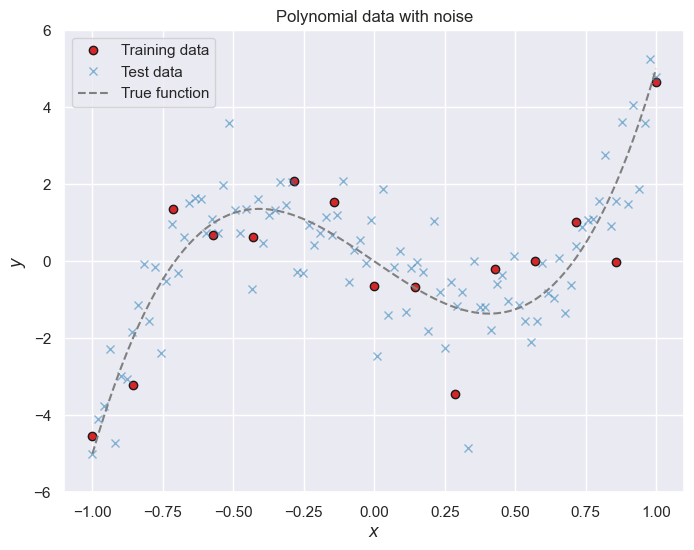

In [2]:
# Set random seed for reproducibility
np.random.seed(seed)
# Define data-generating function
func = lambda x: 10 * x**3 - 5 * x
# Generate training data from polynomial
N_train = 15
X_train = np.linspace(-1, 1, N_train).reshape(-1,1) # Training inputs
y_train = func(X_train) + np.random.randn(N_train).reshape(-1,1) # Training outputs with noise
# Generate test data from polynomial
N_test = 100
X_test = np.linspace(-1,1, N_test).reshape(-1,1) # Test inputs
y_test = func(X_test) + np.random.randn(N_test).reshape(-1,1) # Test outputs with noise

# Combine train and test data for later use. 
X = np.vstack((X_train, X_test))
y = np.vstack((y_train, y_test))

# Plot the data using the function
fig, ax = plt.subplots(figsize=(8, 6))
plot_polynomial_data(X_train, y_train, X_test, y_test=y_test, func=func, ax=ax)
ax.set_title("Polynomial data with noise")
ax.legend()
plt.show()

Last week we saw that the parameters of a linear regression model can be found by minimizing the least squares error. In matrix form, this gives a closed-form solution for the weights.

$$
    \boldsymbol{w}^\ast = \left(\tilde{\boldsymbol{X}}^\top \tilde{\boldsymbol{X}}\right)^{-1} \tilde{\boldsymbol{X}}^\top \boldsymbol{y}
$$

Where $\tilde{\boldsymbol{X}}$ is the design matrix, which **includes a column of ones** to account for the **bias** term.

In practice, instead of computing this directly, we can rely on `sklearn.linear_model.LinearRegression()` to estimate the model.

If we want to extend linear regression to handle polynomials (for example, fitting curves instead of just straight lines), we can do this by **first expanding our input features into polynomial terms** - we also did this in closed-form last week. In scikit-learn, this expansion is handled by `sklearn.preprocessing.PolynomialFeatures(degree)`.

To keep everything organized and **automated**, `scikit-learn` provides **pipelines**. A pipeline lets us chain together preprocessing steps (like adding polynomial features) with a final estimator (like linear regression). By specifying the degree in `PolynomialFeatures`, the **pipeline will automatically transform the input data and then fit the regression model on the transformed version** - the pipeline can be created with `sklearn.pipeline.make_pipeline()`.

**Task 1.1:** Initialize the model-pipeline, choose a polynomial degree, and fit it on the training points. Can you make the model fit the true function well?

> *Hint:* Remember to reshape `X_train`.

> *Hint:* The plotting function takes the fitted model as input, and plots the predictions on a predefined grid.

(15, 1)


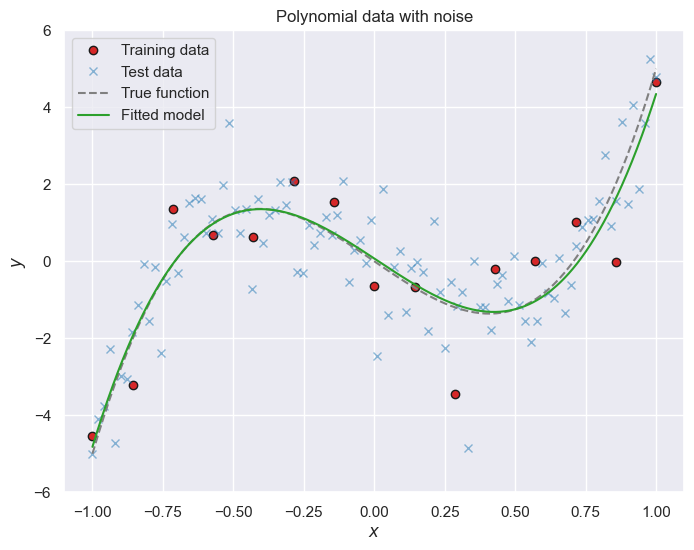

In [14]:
print(X_train.shape)

# 1.1) Fit polynomial model
degree = 3
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())   
# 1. transform input data to polynomial features 
# 2. then fit linear regression
model.fit(X_train.reshape(-1, 1), y_train)

# Plot the data using the function, now with the fitted model
fig, ax = plt.subplots(figsize=(8, 6))
plot_polynomial_data(X_train, y_train, X_test, y_test=y_test, func=func, model=model, ax=ax)
ax.set_title("Polynomial data with noise")
ax.legend()
plt.show()

**Task 1.2:** Experiment with different polynomial degrees. Can you make the model so simple that it simply fits a slope? 
> *Hint:* Make the model more simple by decreasing the degree.

> *Hint:* This is what's known as underfitting. 

**Task 1.3:** Can you make the model so complex that it fits the training data exactly (matching every point)? 
> *Hint:* Make the model more complex by increasing the degree.

> *Hint:* This is what's known as overfitting. 

We’ll now examine how the training and test errors change as we vary the polynomial degree, moving from underfitting to overfitting.

**Task 1.4:** Use the model to predict on the train and test data, calculate the RMSE and save them as `RMSE_train` and `RMSE_test`.

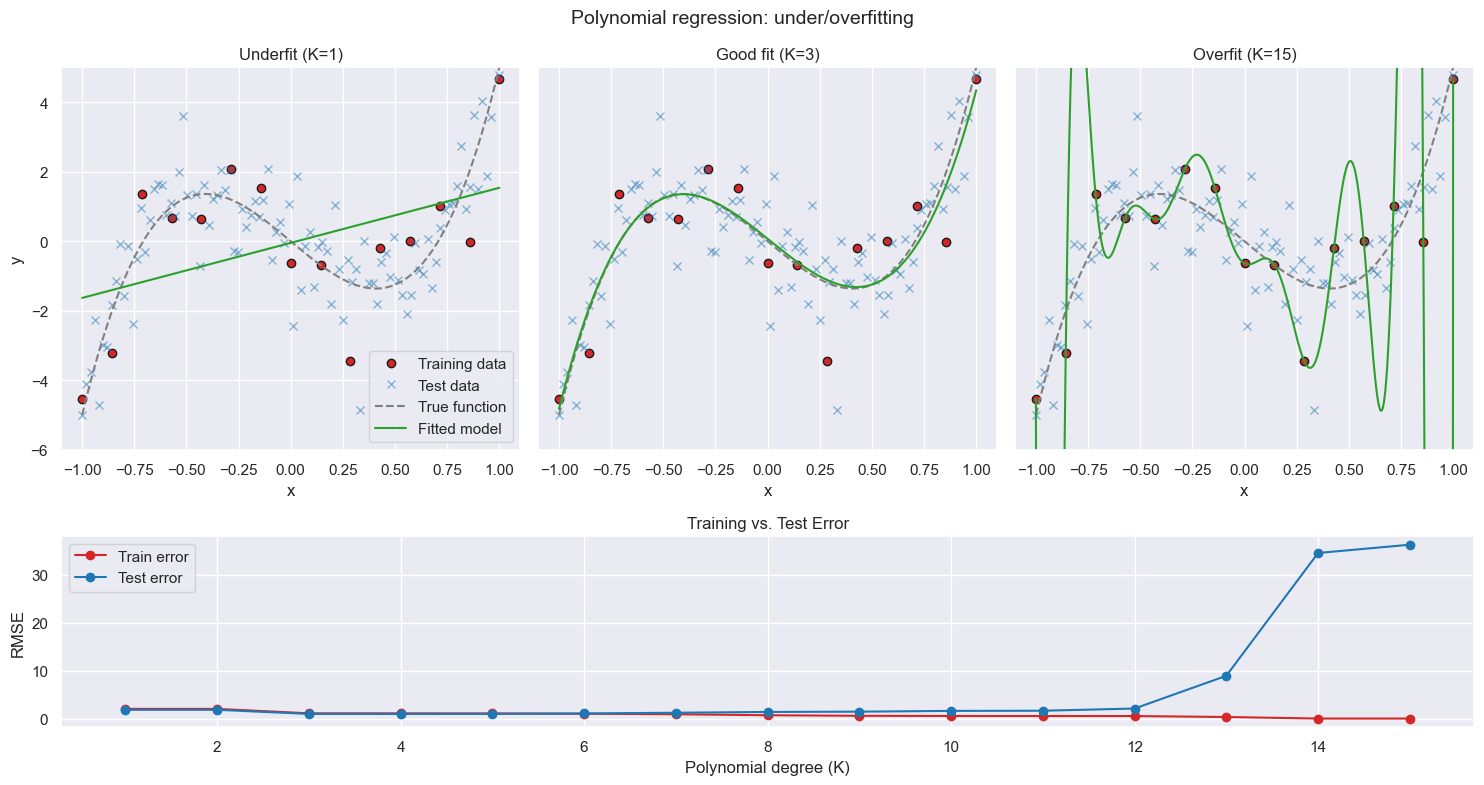

In [15]:
# Setting up figure
fig = plt.figure(figsize=(15, 8))
fig.suptitle("Polynomial regression: under/overfitting", fontsize=14)
# Top: Three columns for three degrees
gs = gridspec.GridSpec(2, 3, height_ratios=[2, 1])
axes_top = [fig.add_subplot(gs[0, i]) for i in range(3)]
# Bottom: Combine three column
ax_bottom = fig.add_subplot(gs[1, :])  # span all 3 columns

# Degrees and titles for the three columns
degrees = [1, 3, 15]
titles = [f"Underfit (K={degrees[0]})",
          f"Good fit (K={degrees[1]})",
           f"Overfit (K={degrees[2]})"]

# Model fitting / prediction and plotting
for ax, degree, title in zip(axes_top, degrees, titles):
    
    # Create and fit the model.
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_train.reshape(-1, 1), y_train)

    # Plot the data and the model
    plot_polynomial_data(X_train, y_train, X_test, y_test, func, model=model, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("x")
    ax.yaxis.set_visible(False)
    ax.grid(True)
    ax.set_ylim(-6, 5)

# Show legend and y-axis on first subplot
axes_top[0].set_ylabel("y")
axes_top[0].yaxis.set_visible(True)
axes_top[0].legend(loc="best")

# Fit and predict for K = 1..15
max_degree = max(degrees)
train_errors, test_errors = [], []

for degree in range(1, max_degree + 1):

    # Create and fit the model.
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_train.reshape(-1, 1), y_train)

    # 1.4) Predict on training and test data, calculate the root mean square error and save them as RMSE_train and RMSE_test.
    ### BEGIN SOLUTION
    y_train_pred = model.predict(X_train.reshape(-1, 1))
    y_test_pred  = model.predict(X_test.reshape(-1, 1))

    RMSE_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    RMSE_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    ### END SOLUTION

    # Store the errors
    train_errors.append(RMSE_train)
    test_errors.append(RMSE_test)

ax_bottom.plot(range(1, max_degree + 1), train_errors, "-o", color="tab:red", label="Train error")
ax_bottom.plot(range(1, max_degree + 1), test_errors, "-o", color="tab:blue", label="Test error")
ax_bottom.set_xlabel("Polynomial degree (K)")
ax_bottom.set_ylabel("RMSE")
ax_bottom.set_title("Training vs. Test Error")
ax_bottom.legend()
ax_bottom.grid(True)

plt.tight_layout()
plt.show()


This should serve as an example of **over-** and **underfitting**. A model that’s too simple can’t capture the training data well, while a model that’s too complex ends up relying too heavily on the training data and fails on new, unseen test data.
<br> In this case, you can see the model fitting the training points perfectly, but that “perfection” actually hurts its ability to generalize.

The bottom plot shows this trade-off: the training error keeps going down as the model gets more complex, but at some point the test error starts to rise sharply. <br>

So how do we stop a model from overfitting? One way is to simplify the model by reducing the number of weights, as we have just seen above. <br> Another is to give it more training data, such that the model has a better chance to learn the real patterns, rather than the noise. In the coming weeks, we’ll also see how **regularization** can help address overfitting.

**Task 1.5:** Increase the number of training points in the above examples. What happens to the overfitted model when $N_{train}=50, 100, 1000$?


---
## Part 2: Approximating Generalization Error through Cross-Validation

In the above example, you saw how the **test error** is a much better representation of the true performance of the model than the **training error**. As you might have noticed in the code-block, we used the *holdout*-method, where the data is split into a single *training-* and *testset*. 
<br> In cases of small test-sets, this might lead to a crude approximation of the actual generalization error - as the data might be randomly be split into sets that don't represent the actual distribution well. 
We will therefore look at more comprehensive methods of estimating the **generalization error**, through **cross-validation**.

As you might recall from the lecture, **the generalization error is the test error evaluated over an *infinitely* large test set.** <br> 
In other words, it's the "true performance" of a model, if we were to test it on an infinite amount of new, unseen data.

Intuitively, this is simply not feasible in the real world, where data is often limited, and thus our only option is to **estimate** the generalization error instead. 

Cross-validation is a method we use to estimate the generalization error, and it is particularly useful when we don't have a lot of data. We will look at three different methods:
1) **Holdout**: Partitions dataset in two (training, test), we approximate the generalization error based on the resulting test set.

2) **K-fold**: Partitions dataset $K$ times, such that all observations get to act as test-points in a single fold. We train the model $K$ times and approximate the generalization error by averaging over the $K$ test results.

3) **Leave-one-out**: Partitions dataset into as many folds as there are observations, such that each observation acts as a test point once. We train the model $N$ times (where $N$ is the number of samples) and approximate the generalization error by averaging over all $N$ test results.

Each of the three methods has its own advantages and drawbacks. In general, **increasing the number of folds gives us a more reliable estimate of the generalization error, but it also requires training more models and therefore consumes more computational resources.** With the holdout method, there is always the risk of an “unlucky” split, where the training and test sets do not represent the overall data distribution well, leading to an unreliable performance estimate. <br>

As a rule of thumb: **<u>the more data we have, the fewer folds we need.</u>**

In this exercise, we will compare three approaches to splitting the data: **holdout**, **K-fold**, and **leave-one-out**. <br> For each method, we will once again fit a 3rd degree polynomial to the above data - and compare the results we find in each fold, as well as across methods. 

**Task 2.1:** Split $\boldsymbol{X}$ and $\boldsymbol{y}$ into a training and test split with the holdout method, using a 80/20 split.  
> *Hint:* Use the function `train_test_split()`.

> *Hint:* Remember to use `random_state = seed`.

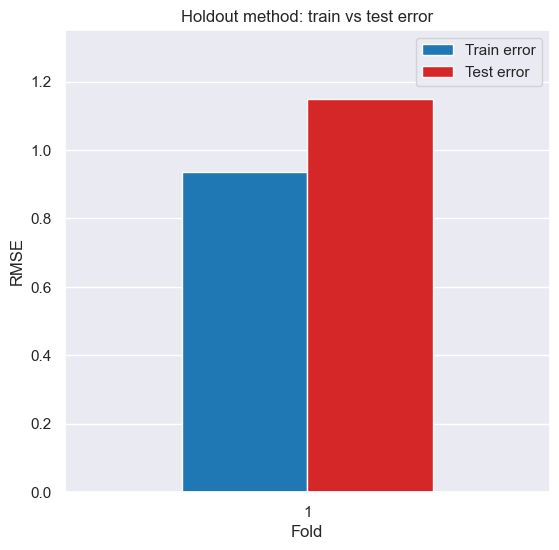

In [16]:
# Dictionary to store errors for each method
errors = {}
degree = 3 # Use degree 3 for the rest of the exercise

# 2.1) Holdout Method (20% test size) - split X and y into X_train, X_test, y_train, y_test
### BEGIN SOLUTION
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed
)
### END SOLUTION

# Initialize model
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
# Fit model
model.fit(X_train.reshape(-1, 1), y_train)
# Predict
y_train_pred = model.predict(X_train.reshape(-1, 1))
y_test_pred  = model.predict(X_test.reshape(-1, 1))

# Compute errors
train_error = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_error  = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Bar plot "holdout" train and test error
plot_fold_errors(np.array([(train_error, test_error)]))
plt.title('Holdout method: train vs test error')
plt.show()

# Save mean errors for later comparison
errors['Holdout'] = (train_error, test_error)

**Task 2.2:** Initialize the K-fold method with $K=5$, save it as `CV_kfold`.
> *Hint:* Use the function `KFold()`.

> *Hint:* Remember to set `shuffle=True` and use `random_state=seed` - why is that important with K-fold?

**Task 2.3:** Split $\boldsymbol{X}$ and $\boldsymbol{y}$ into a training and test split within each fold.

> *Hint:* Index `X` and `y` by the indexes provided in the for-loop.

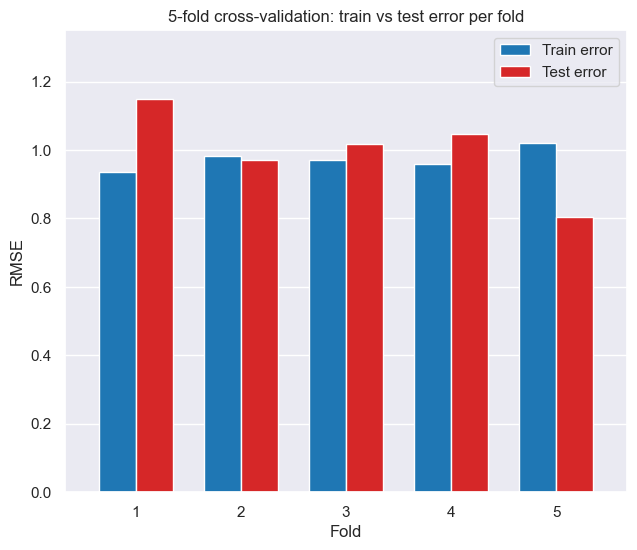

In [17]:
degree = 3
# Empty list to store errors for each fold
fold_errors = []

# 2.2) Initialize 5-Fold Cross-Validation, save the object as CV_kfold
### BEGIN SOLUTION
K = 5
CV_kfold = KFold(n_splits=K, shuffle=True, random_state=seed)
### END SOLUTION

# Loop through the folds
for fold, (train_index, test_index) in enumerate(CV_kfold.split(X)):

    # 2.3) Split X and y into X_train, X_test, y_train and y_test according to the current fold.
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Initialize and fit model.
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_train.reshape(-1, 1), y_train)
    # Predict
    y_train_pred = model.predict(X_train.reshape(-1, 1))
    y_test_pred  = model.predict(X_test.reshape(-1, 1))

    # Compute errors
    train_error = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_error  = np.sqrt(mean_squared_error(y_test, y_test_pred))

    fold_errors.append((train_error, test_error))

# Bar plots for each fold train and test error
fold_errors = np.array(fold_errors)
plot_fold_errors(fold_errors)
plt.title('5-fold cross-validation: train vs test error per fold')
plt.show()

# Save mean errors for later comparison
errors['5-Fold CV'] = (np.mean(fold_errors[:, 0]), np.mean(fold_errors[:, 1]))

**Task 2.4:** Initialize the LeaveOneOut method, save it as `CV_loo`.
> *Hint:* Use the function `LeaveOneOut()`. 

> *Hint:* Why do we not need to shuffle the data and set a seed using this method?

**Task 2.5:** Split $\boldsymbol{X}$ and $\boldsymbol{y}$ into a training and test split within each fold.
> *Hint:* Index `X` and `y` by the indexes provided in the for-loop.

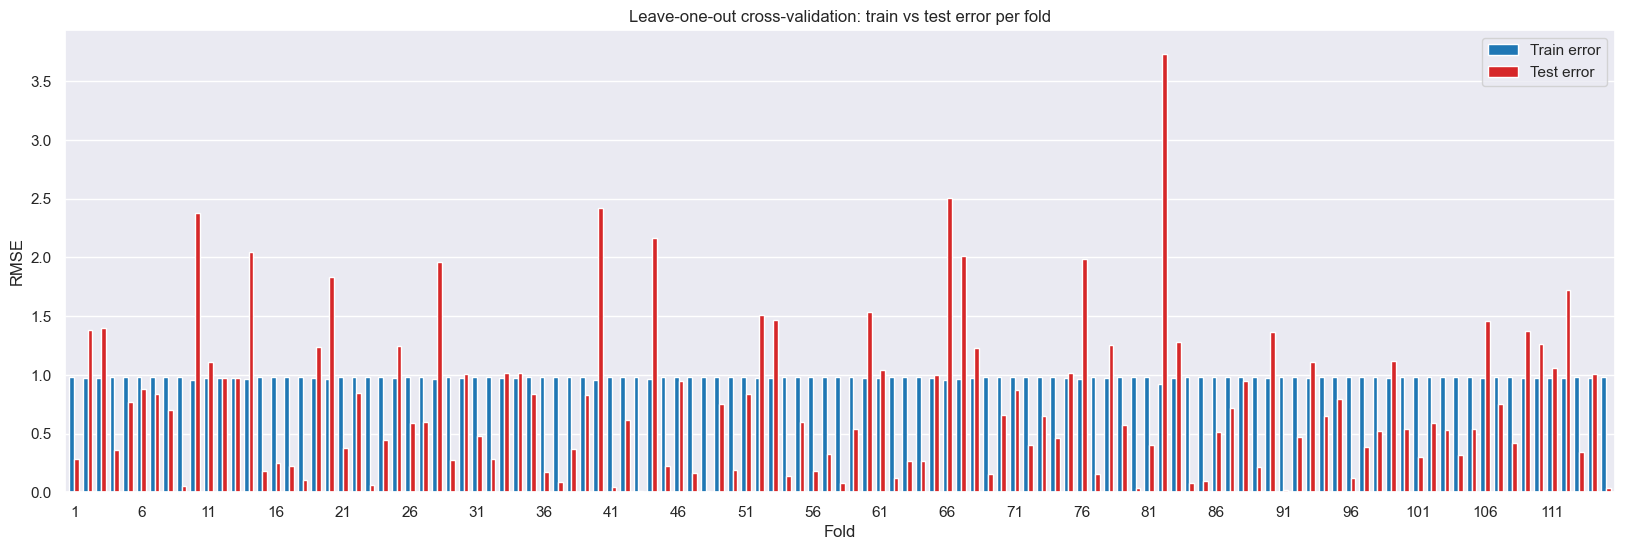

In [18]:
# Empty list to store errors for each fold
fold_errors = []

# 2.4) Leave-one-out cross-validation
### BEGIN SOLUTION
CV_loo = LeaveOneOut()
### END SOLUTION

# Loop through the folds
for fold, (train_index, test_index) in enumerate(CV_loo.split(X)):
    # 2.5) Split X and y into X_train, X_test, y_train and y_test according to the current fold.
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Initialize model
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    # Fit model
    model.fit(X_train.reshape(-1, 1), y_train)
    # Predict
    y_train_pred = model.predict(X_train.reshape(-1, 1))
    y_test_pred  = model.predict(X_test.reshape(-1, 1))

    # Compute errors
    train_error = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_error  = np.sqrt(mean_squared_error(y_test, y_test_pred))

    fold_errors.append((train_error, test_error))

# Bar plots for each fold train and test error
fold_errors = np.array(fold_errors)
plot_fold_errors(fold_errors)
plt.title('Leave-one-out cross-validation: train vs test error per fold')
plt.show()


# Save mean errors for later comparison
errors['LeaveOneOut CV'] = (np.mean(fold_errors[:, 0]), np.mean(fold_errors[:, 1]))

**Task 2.6:** How come the test results vary so much from fold to fold in the cases of K-fold and leave-one-out? Relate it to the single fold of holdout, and why these methods are better at estimating the Generalization Error. 
- *Answer:* 

The holdout method uses a single split of the data into training and test sets, which can lead to high variance in the test results depending on how the data is split. If the split is not representative of the overall data distribution, the test results may not accurately reflect the model's performance on unseen data.\
$\quad \rightarrow$ high variance, high bias.

On the other hand, K-fold and leave-one-out cross-validation involve multiple splits of the data, allowing each observation to be used as a test point at least once. This averaging over multiple test results helps to mitigate the impact of any single "unlucky" split, leading to a more reliable estimate of the model's generalization error.\
$\quad \rightarrow$ LOOV has low bias but high variance\
$\quad \rightarrow$ K-fold has a good balance between bias and variance.

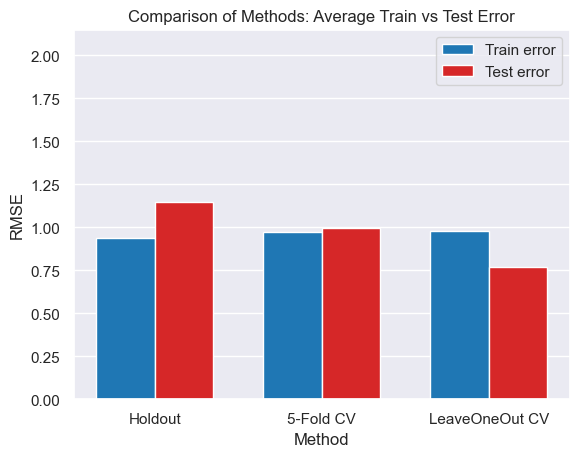

In [19]:
# Bar plot of all methods
f = plt.figure()
plt.title('Comparison of Methods: Average Train vs Test Error')
bar_width = 0.35
index = np.arange(len(errors))
train_errs = [v[0] for v in errors.values()]
test_errs  = [v[1] for v in errors.values()]
plt.bar(index, train_errs, bar_width, color='tab:blue', label='Train error')
plt.bar(index + bar_width, test_errs, bar_width, color='tab:red', label='Test error')
plt.xlabel('Method')
plt.ylabel('RMSE')
plt.xticks(index + bar_width / 2, [k for k in errors.keys()])
plt.ylim(0, max(train_errs + test_errs) + 1)
plt.legend()
plt.grid(axis='x')
plt.show()

**Task 2.7:** Which is a more accurate estimation of the Generalization Error?
- *Answer:* Leave-one-out cross-validation (LOOCV) is generally considered a more accurate estimation of the generalization error because it uses almost all available data for training in each iteration, only leaving out one observation for testing. This results in a more reliable estimate of the model's performance on unseen data.

**Task 2.8:** How come leave-one-out gets a lower test error than 5-fold? Try thinking of how many data points were used when training the models within each fold.
- *Answer:* Leave-one-out cross-validation (LOOCV) uses almost all data points for training in each iteration, only leaving out one data point for testing. In contrast, 5-fold cross-validation uses only 80% of the data for training in each fold, which may not capture the underlying data distribution as effectively as LOOCV. This can lead to higher test errors in 5-fold cross-validation compared to LOOCV.

---
## Part 3: Cross-Validation for Model Evaluation

When optimizing our models, we'd like to make sure the estimate of our generalization error is as good as possible, so we can make sure we've chosen the best parameters. In this exercise, we will be using leave-one-out CV, to evaluate the performance of KNN models with $K = 1, 2, \dots, 40$ on the Iris dataset, to find the best performing number of neighbours, $K$.

**Task 3.1:** Load the Iris dataset into $\boldsymbol{X}$ and $\boldsymbol{y}$.
> *Hint:* Remember to make $\boldsymbol{y}$ categorical.

In [20]:
### BEGIN SOLUTION
# Load the iris dataset
df = pd.read_csv("data/iris.csv")

# Split the data frame into features and labels
X = df.drop(columns=["Type"])
y = pd.Categorical(df["Type"])
### END SOLUTION

assert X.shape == (150, 4), "There should be 150 samples and 4 features in the Iris dataset."
assert y.shape == (150,), "There should be 150 labels in the Iris dataset."

**Task 3.2:** Implement leave-one-out cross-validation in the code below. 
> *Hint:* Use `LeaveOneOut()` for the cross-validation.

**Task 3.3:** Split $\boldsymbol{X}$ and $\boldsymbol{y}$ according to the current fold in the for-loop.
> *Hint:* You might have to use `.iloc` as we're using Pandas for our data.

**Task 3.4:** For each fold, loop over the different values of $k$. For each $k$, define a KNN model with $k$ neighbors, fit it, make predictions, and compute the classification error. Store the result in `errors[fold, k - 1]`.
> *Hint:* Use `KNeighborsClassifier` from `sklearn.neighbours`.

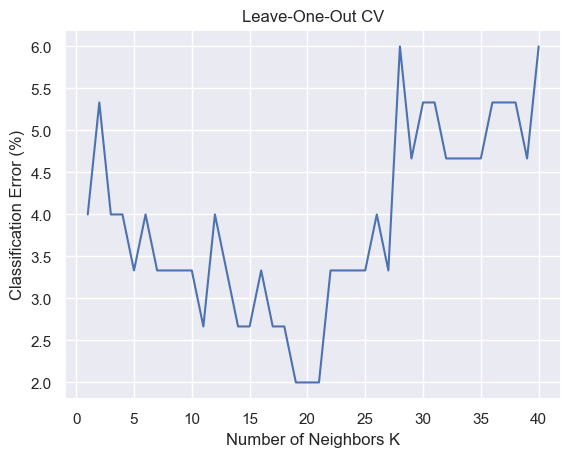

In [28]:
K_neighbours = 40  # Max neighbors
errors = np.zeros((len(X), K_neighbours))

# 3.2) Implement leave-one-out cross-validation.
### BEGIN SOLUTION
CV_loo = LeaveOneOut()
### END SOLUTION

# Loop through the folds
for fold, (train_index, test_index) in enumerate(CV_loo.split(X)):
    # 3.3) Split X and y according to the current fold, name them X_train, X_test, y_train, y_test.
    ### BEGIN SOLUTION
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    ### END SOLUTION

    for k in range(1, K_neighbours + 1):
        # 3.4) For each $k$, define a KNN model with $k$ neighbors, fit it, make predictions.
        # Compute the classification error. 
        # Store the result in errors[fold, k - 1]
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        classification_error = np.mean(y_pred != y_test)
        errors[fold, k - 1] = classification_error

# Plot mean errors for each K
mean_errors = np.mean(errors, axis=0)
f = plt.figure()
plt.title('Leave-One-Out CV')
plt.xlabel('Number of Neighbors K')
plt.ylabel('Classification Error (%)')
plt.plot(range(1, K_neighbours + 1), mean_errors * 100)
plt.grid(True)
plt.show()

**Task 3.4:** Argue the number of neighbours that would be optimal for our KNN model on the Iris data. How come the estimated generalization error suddenly rises after the classification error minima?
- *Answer:* 

**Task 3.5:** Try switching out the model for a Decision Tree instead, evaluate the best depth. 

**Task 3.6:** Try exchanging the LOO for Holdout and 10-fold CV and time the run-time. What's the time difference, and how come?
> *Hint:* You might not even have to change the code, can you think of a way to calculate an estimation of the time difference?

### Decision tree instead of KNN

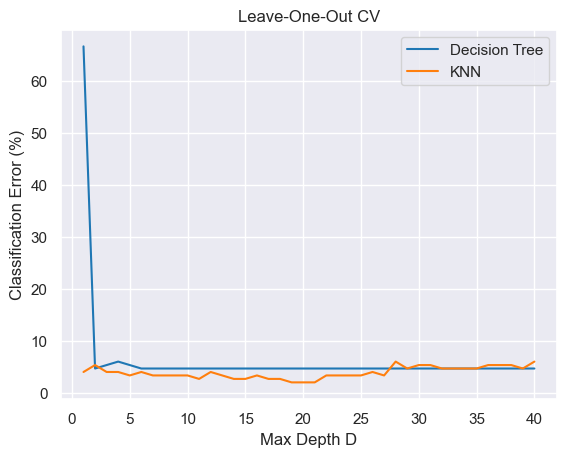

In [29]:
from sklearn.tree import DecisionTreeClassifier

D_max = 40 # max depth of the tree
errors_DT = np.zeros((len(X), D_max))

# 3.2) Implement leave-one-out cross-validation.
### BEGIN SOLUTION
CV_loo = LeaveOneOut()
### END SOLUTION

# Loop through the folds
for fold, (train_index, test_index) in enumerate(CV_loo.split(X)):
    # 3.3) Split X and y according to the current fold, name them X_train, X_test, y_train, y_test.
    ### BEGIN SOLUTION
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    ### END SOLUTION

    for d in range(1, D_max + 1):
        # 3.4) For each $d$, define a Decision Tree model with max depth $d$, fit it, make predictions.
        # Compute the classification error. 
        # Store the result in errors[fold, k - 1]
        model = DecisionTreeClassifier(max_depth=d, random_state=seed)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        classification_error = np.mean(y_pred != y_test)
        errors_DT[fold, d - 1] = classification_error

# Plot mean errors for each D
mean_errors_DT = np.mean(errors_DT, axis=0)
f = plt.figure()
plt.title('Leave-One-Out CV')
plt.xlabel('Max Depth D')
plt.ylabel('Classification Error (%)')
plt.plot(range(1, D_max + 1), mean_errors_DT * 100, color='tab:blue', label='Decision Tree')
plt.plot(range(1, K_neighbours + 1), mean_errors * 100, color='tab:orange', label='KNN')
plt.grid(True)
plt.legend()
plt.show()

Plot the decision boundary for KNN and DT:

/Users/vincent/anaconda3/envs/DTU_machine-learning/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


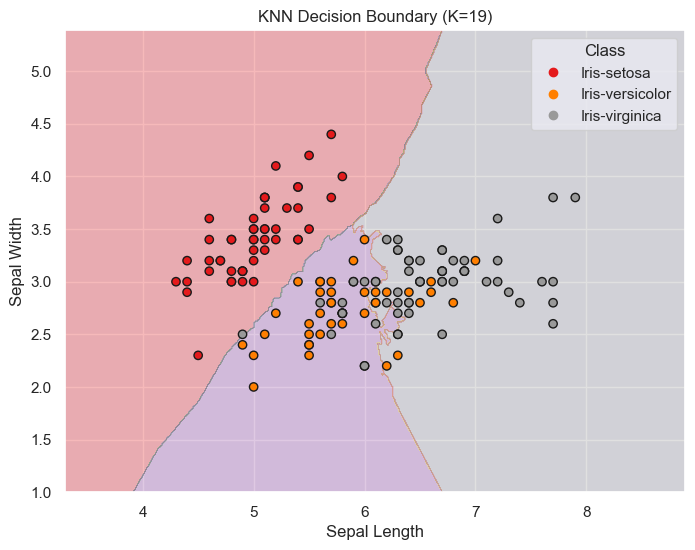

/Users/vincent/anaconda3/envs/DTU_machine-learning/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


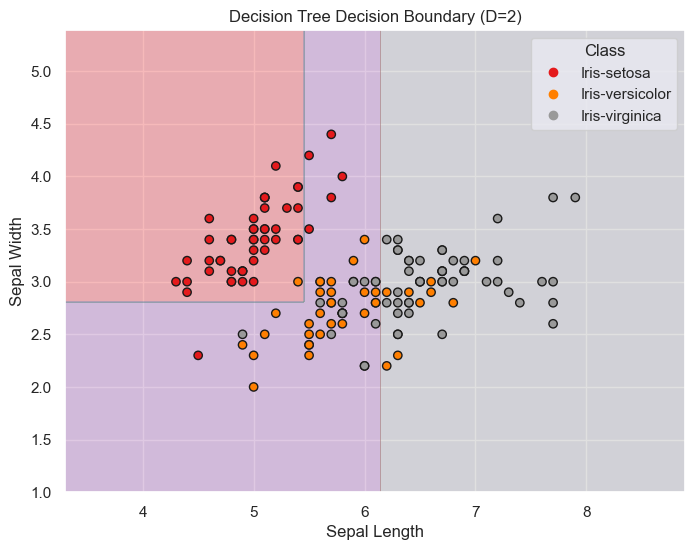

In [34]:
# Plot the decision boundary for KNN and DT:
def plot_decision_boundary(model, X, y, title):
    # Define bounds of the domain
    x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
    y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
    # Predict class using the trained model
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = pd.Categorical(Z, categories=y.categories).codes  # ensure Z is numeric for contourf
    Z = Z.reshape(xx.shape)
    
    # Create contour plot
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Set1)
    scatter = plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y.codes, edgecolor='k', cmap=plt.cm.Set1)
    plt.xlabel(X.columns[0])
    plt.ylabel(X.columns[1])
    plt.title(title)
    handles, _ = scatter.legend_elements()
    plt.legend(handles, y.categories, title="Class")
    plt.show()
    
# Train KNN with optimal K using only the first two features
optimal_k = np.argmin(mean_errors) + 1 # +1 because index starts at 0
knn_model = KNeighborsClassifier(n_neighbors=optimal_k)
knn_model.fit(X.iloc[:, :2], y)
plot_decision_boundary(knn_model, X.iloc[:, :2], y, f'KNN Decision Boundary (K={optimal_k})')

# Train Decision Tree with optimal D using only the first two features
optimal_d = np.argmin(mean_errors_DT) + 1 # +1 because index starts at 0
dt_model = DecisionTreeClassifier(max_depth=optimal_d, random_state=seed)
dt_model.fit(X.iloc[:, :2], y)
plot_decision_boundary(dt_model, X.iloc[:, :2], y, f'Decision Tree Decision Boundary (D={optimal_d})')



---
## Part 4: Feature Selection through 2-layer cross-validation
In this exercise we consider cross-validation for variable selection and model performance evaluation in linear regression. We will try to predict the body-weight of a person, based on a number of body measurements, using linear regression with feature subset selection. 

The data can be found in the `body.csv` file, and is a subset of the data available [here](http://www.sci.usq.edu.au/courses/STA3301/resources/Data/). To measure how well we can predict the body-weight, we will use the mean squared error (MSE) between the true and estimated body-weight.

We will make use of two layers of cross-validation to perform our feature selection. 
1) In the outer layer, we use 5-fold cross-validation to estimate the performance of our model, i.e., we compute the squared error averaged over 5 outer test sets. 
2) In the inner layer, we use 10-fold cross-validation to perform sequential feature selection.
    - We start by evaluating each feature in the 10 inner folds - the best feature moves on, and we sequentially add more features until no improvement can be found. 

The best model found within each outer fold, is then finally tested on its corresponding outer test fold. 

The process is also described in this visualization:
<p align="center">
  <img src="2layerCV.jpg" alt="Two-layer cross-validation" height="400px">
</p>

The code will produce 6 plots - the first 5 describe the results of each outer fold. 
- (Left): The MSE found for each sequentially added feature across the iterations, for the corresponding fold. 
- (Right): A grid showing which features were used in each iteration, for the corresponding fold. 

The last plot describes 
- (Left): The outer test MSE found for the best model, on each fold.
- (Right): The best features found for each fold. 

**Task 4.1:** Get acquainted with the figure above - make sure you understand how the 2-layer CV works, and what is supposed to happen in the inner and outer folds. 

**Task 4.2:** Load the `body.csv` into pandas, split into X and y (`weight`).

In [35]:
### BEGIN SOLUTION

# Load the body dataset
df = pd.read_csv("data/body.csv")

# Split the data frame into features and labels
X = df.drop(columns=["weight"])
y = df["weight"]

### END SOLUTION

assert X.shape == (30, 23), "There should be 30 samples and 23 features in the Body dataset."
assert y.shape == (30,), "There should be 30 labels in the Body dataset."

**Task 4.3:** Split `X` and `y` into an outer training and test split within each outer fold.
> *Hint:* Name them `X_train_outer`, `X_test_outer`, `y_train_outer`, `y_test_outer`.

> *Hint:* Index by the indices provided in the outer CV-loop - remember to use `.iloc`.

**Task 4.4:** Split `X_train_outer` and `y_train_outer` into an inner training and test split within each inner fold.
> *Hint:* Name them `X_train_inner`, `X_test_inner`, `y_train_inner`, `y_test_inner`.

> *Hint:* Index by the indices provided in the inner CV-loop - remember to use `.iloc`.

**Task 4.5:** Fill in the code to create the Linear Regression model, fit, and predict in both the inner and outer fold. 
> *Hint:* Remember `fit_intercept=True`.

> *Hint:* In the inner folds: Only fit and test the model on the `candidate_features`.

> *Hint:* In the outer folds: Only fit and test the model on the `selected_features`.

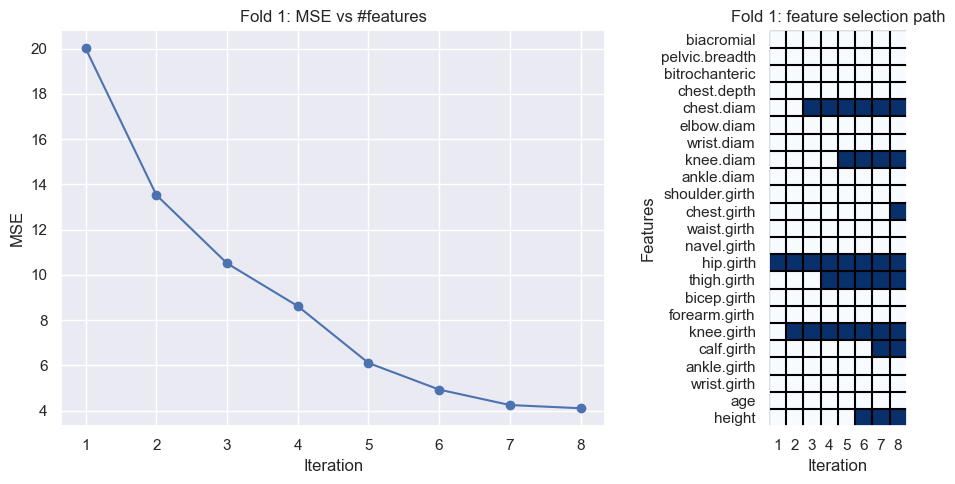

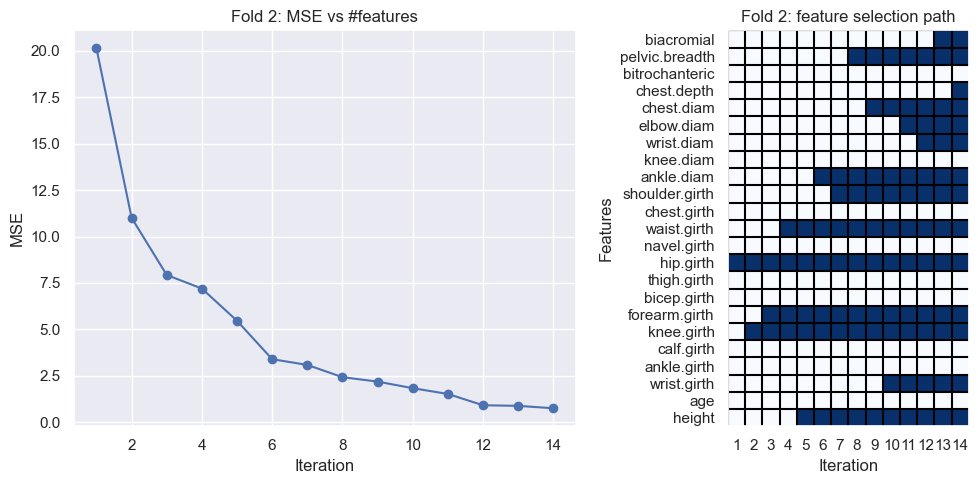

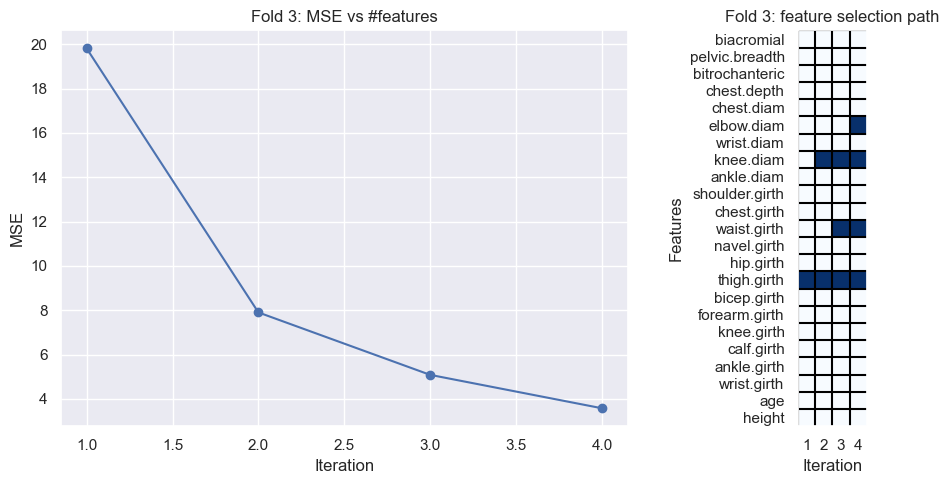

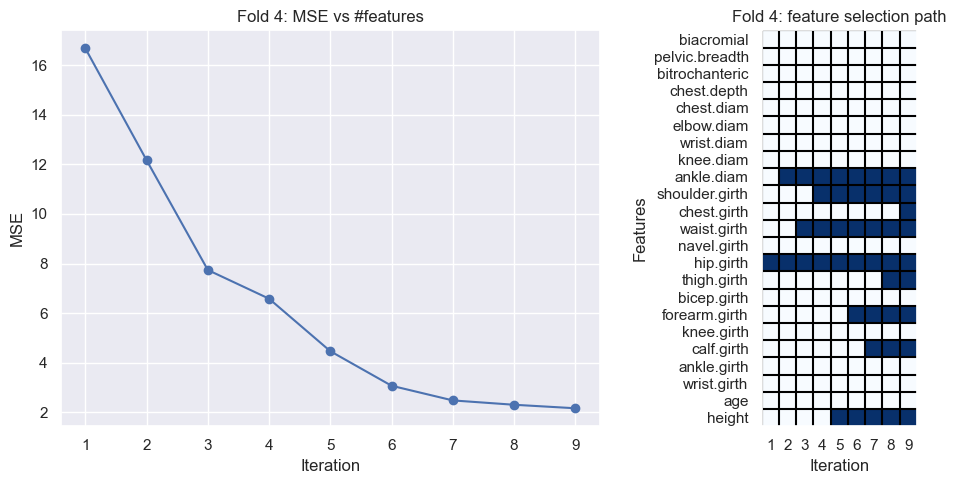

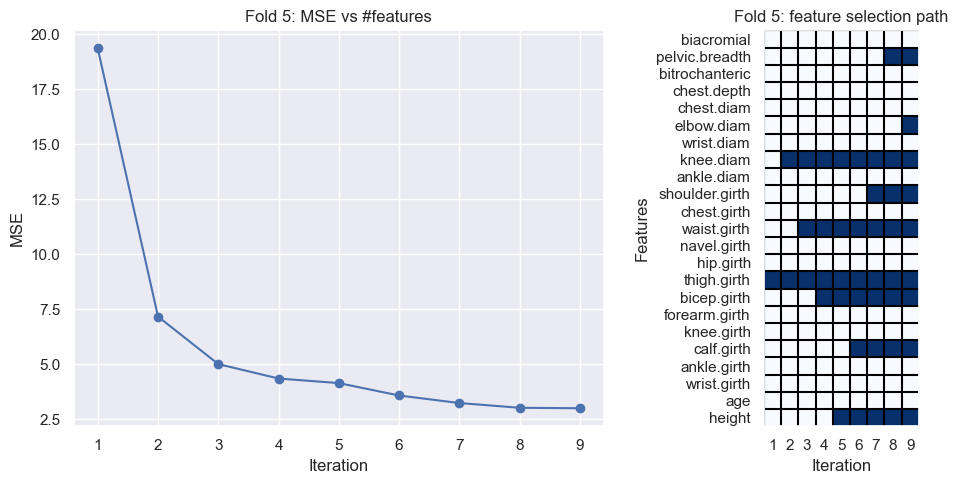

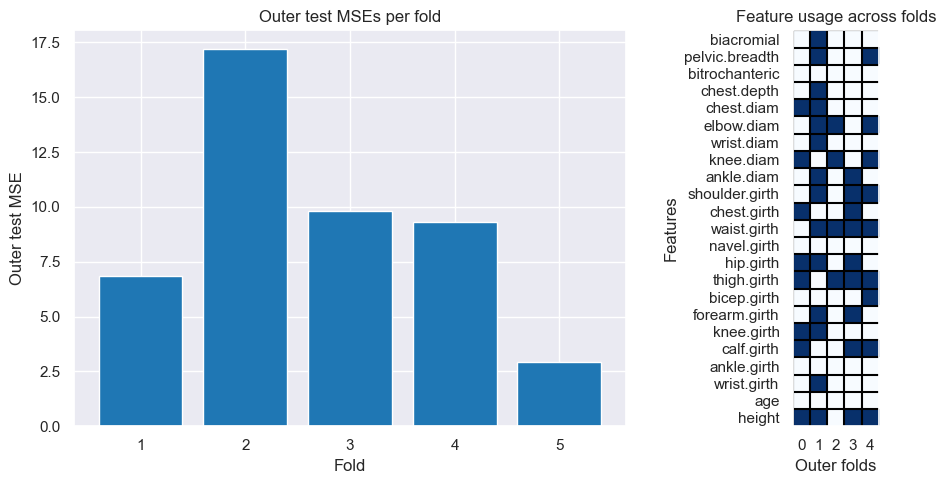

In [36]:
def sequential_feature_selection(X, y, outer_folds=5, inner_folds=10, random_state=42):
    CV_outer = KFold(n_splits=outer_folds, shuffle=True, random_state=random_state)

    fold_results = []  # store per-fold feature paths & errors
    outer_test_mse = []

    for outer_train_idx, outer_test_idx in CV_outer.split(X):

        # 4.3) Split X and y into training/testing data for this outer fold
        # Name them X_train_outer, X_test_outer, y_train_outer, y_test_outer
        ### BEGIN SOLUTION
        X_train_outer, X_test_outer = X.iloc[outer_train_idx], X.iloc[outer_test_idx]
        y_train_outer, y_test_outer = y.iloc[outer_train_idx], y.iloc[outer_test_idx]
        ### END SOLUTION

        selected_features = []
        mse_per_iteration = []
        remaining_features = list(X.columns)
        best_mse = np.inf

        # Feature addition while-loop, keep adding features until no improvement
        while remaining_features:
            feature_mse = {}

            for feat in remaining_features:
                candidate_features = selected_features + [feat]

                # inner CV
                CV_inner = KFold(n_splits=inner_folds, shuffle=True, random_state=random_state)
                inner_mse = []

                for inner_train_idx, inner_test_idx in CV_inner.split(X_train_outer):

                    # 4.4) Split X_train_outer and y_train_outer into training/testing data for this inner fold.
                    # Name them X_train_inner, X_test_inner, y_train_inner, y_test_inner
                    ### BEGIN SOLUTION
                    X_train_inner, X_test_inner = X_train_outer.iloc[inner_train_idx], X_train_outer.iloc[inner_test_idx]
                    y_train_inner, y_test_inner = y_train_outer.iloc[inner_train_idx], y_train_outer.iloc[inner_test_idx]
                    ### END SOLUTION
                    
                    # 4.5.1) Create Linear Regression model, fit, and predict on the inner sets
                    # - save predictions as y_test_inner_pred.
                    # Remember to only take the candidate_features into consideration.
                    ### BEGIN SOLUTION
                    model = LinearRegression(fit_intercept=True)
                    model.fit(X_train_inner[candidate_features], y_train_inner)
                    y_test_inner_pred = model.predict(X_test_inner[candidate_features])
                    ### END SOLUTION
                    # Add score for this fold
                    inner_mse.append(mean_squared_error(y_test_inner, y_test_inner_pred))

                # Save average MSE with this feature added
                feature_mse[feat] = np.mean(inner_mse)

            # pick best new feature
            best_feat = min(feature_mse, key=feature_mse.get)
            best_feat_mse = feature_mse[best_feat]

            # If best feature improves MSE, add it
            if best_feat_mse < best_mse:
                selected_features.append(best_feat)
                mse_per_iteration.append(best_feat_mse)
                best_mse = best_feat_mse
                remaining_features.remove(best_feat)

            else: # No improvement - get actual test MSE for outer loop, with best feature set.
                
                # 4.5.2) Create Linear Regression model, fit, and predict on the outer sets
                # - save predictions as y_test_outer_pred.
                # Remember to only take the selected_features into consideration.
                ### BEGIN SOLUTION
                model = LinearRegression(fit_intercept=True)
                model.fit(X_train_outer[selected_features], y_train_outer)
                y_test_outer_pred = model.predict(X_test_outer[selected_features])
                ### END SOLUTION

                outer_test_mse = mean_squared_error(y_test_outer, y_test_outer_pred)
                break # Break out of while loop

        fold_results.append({
            "mse": mse_per_iteration,
            "features": selected_features,
            "outer_test_mse": outer_test_mse
        })

    return fold_results


results = sequential_feature_selection(X, y, random_state=1)
plot_seq_feature_results(results, list(X.columns))

**Task 4.5:** The MSE for the 2nd outer fold is much higher than the rest, why might this be? Try relating it to why K-fold is typically better than Holdout at estimating the Generalization Error. 

- *Answer:*

**Task 4.6:** Explain how it can be seen the feature selection tends to choose features such as height and waist girth, and disregard features such as the wrist diameter, which seems reasonable when predicting body-weight.

- *Answer:*

**(Optional) Task 4.7:** The above code does *forward* sequential feature selection. Try copy-pasting the code into a cell below, and modify it such that it performs *backwards* feature selection instead. 

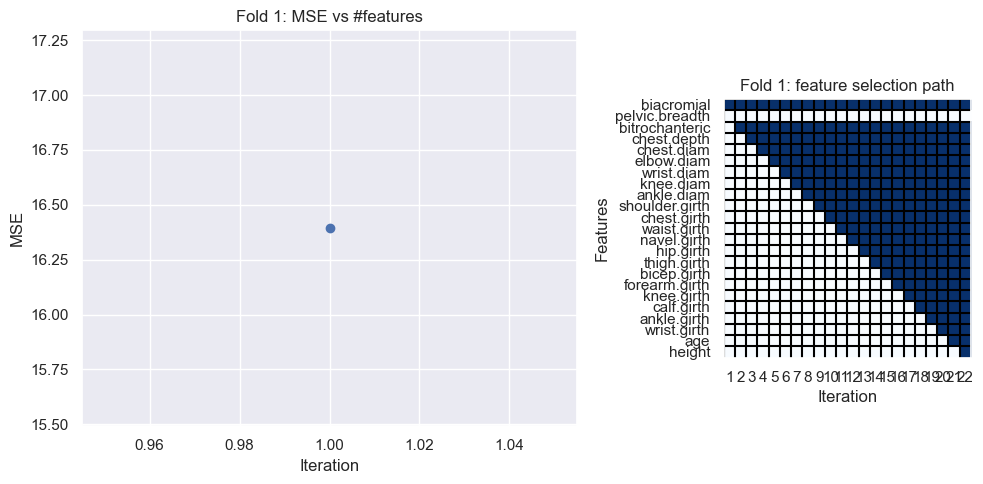

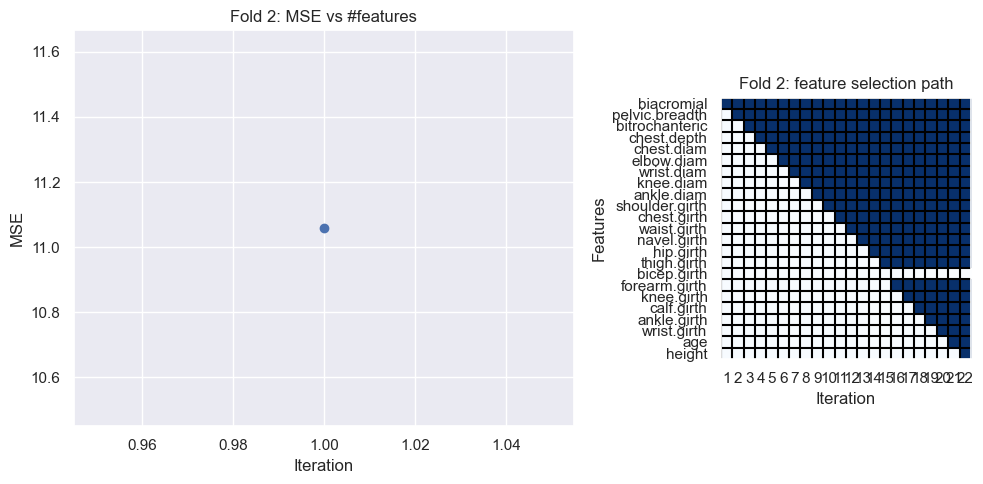

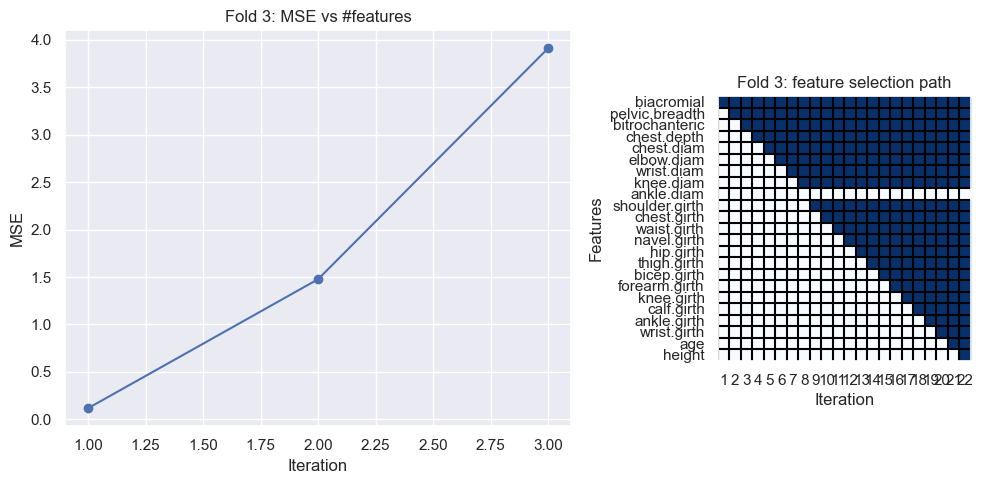

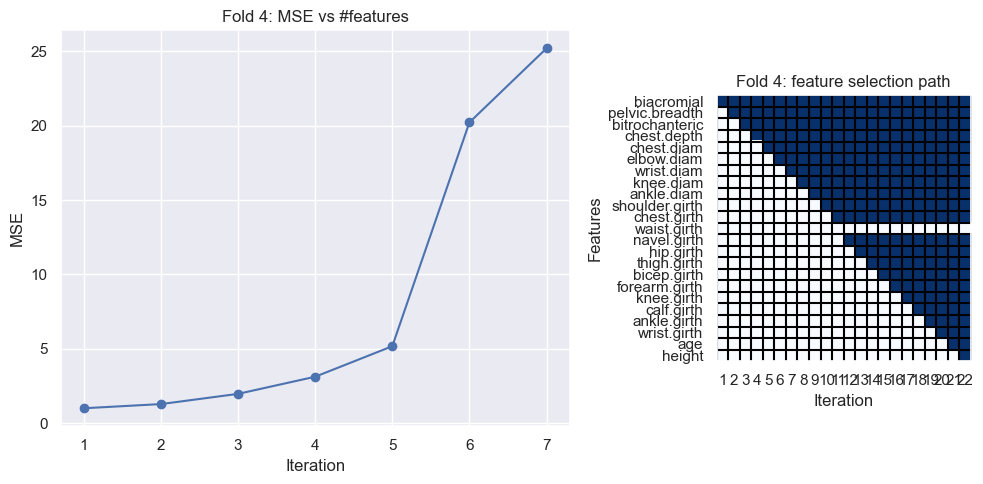

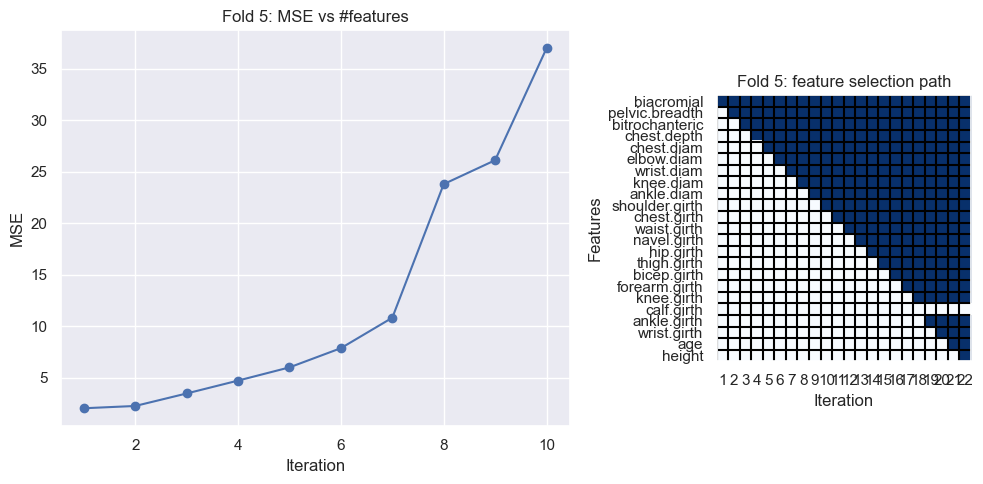

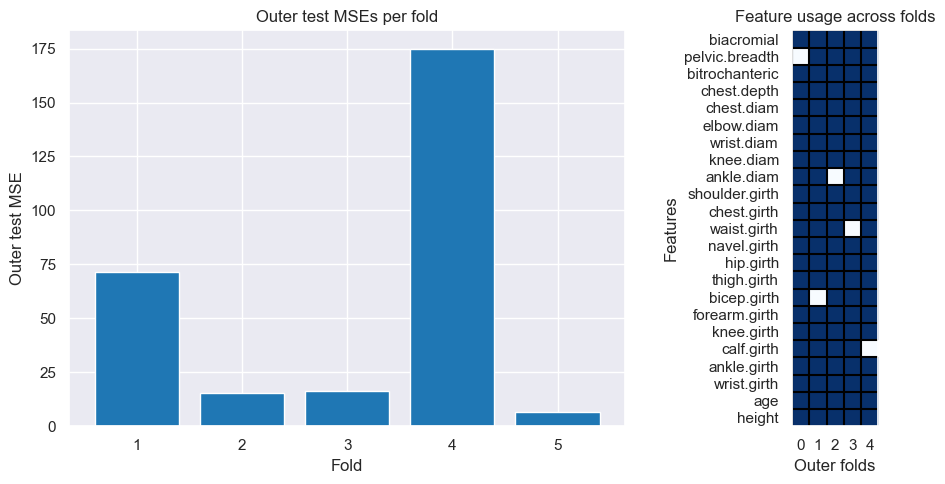

In [ ]:
def backward_feature_elimination(X, y, outer_folds=5, inner_folds=10, random_state=42):
    CV_outer = KFold(n_splits=outer_folds, shuffle=True, random_state=random_state)

    fold_results = []  # store per-fold feature paths & errors
    outer_test_mse = []

    for outer_train_idx, outer_test_idx in CV_outer.split(X):

        # Split outer folds
        X_train_outer, X_test_outer = X.iloc[outer_train_idx], X.iloc[outer_test_idx]
        y_train_outer, y_test_outer = y.iloc[outer_train_idx], y.iloc[outer_test_idx]

        selected_features = list(X.columns)  # start with all features
        mse_per_iteration = []
        best_mse = np.inf

        # Feature removal while-loop, keep removing features until no improvement
        while len(selected_features) > 1:
            feature_mse = {}

            for feat in selected_features:
                candidate_features = [f for f in selected_features if f != feat]

                # inner CV
                CV_inner = KFold(n_splits=inner_folds, shuffle=True, random_state=random_state)
                inner_mse = []

                for inner_train_idx, inner_test_idx in CV_inner.split(X_train_outer):
                    X_train_inner, X_test_inner = X_train_outer.iloc[inner_train_idx], X_train_outer.iloc[inner_test_idx]
                    y_train_inner, y_test_inner = y_train_outer.iloc[inner_train_idx], y_train_outer.iloc[inner_test_idx]

                    model = LinearRegression(fit_intercept=True)
                    model.fit(X_train_inner[candidate_features], y_train_inner)
                    y_test_inner_pred = model.predict(X_test_inner[candidate_features])

                    inner_mse.append(mean_squared_error(y_test_inner, y_test_inner_pred))

                feature_mse[feat] = np.mean(inner_mse)

            # pick best feature to remove (the one whose removal yields the lowest MSE)
            best_feat_to_remove = min(feature_mse, key=feature_mse.get)
            best_feat_mse = feature_mse[best_feat_to_remove]

            # If removal improves MSE, remove it
            if best_feat_mse < best_mse:
                selected_features.remove(best_feat_to_remove)
                mse_per_iteration.append(best_feat_mse)
                best_mse = best_feat_mse

            else:  # No improvement — evaluate on outer test set
                model = LinearRegression(fit_intercept=True)
                model.fit(X_train_outer[selected_features], y_train_outer)
                y_test_outer_pred = model.predict(X_test_outer[selected_features])

                outer_test_mse = mean_squared_error(y_test_outer, y_test_outer_pred)
                break

        fold_results.append({
            "mse": mse_per_iteration,
            "features": selected_features,
            "outer_test_mse": outer_test_mse
        })

    return fold_results


results = backward_feature_elimination(X, y, random_state=1)
plot_seq_feature_results(results, list(X.columns))
